In [1]:
from __future__ import print_function

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import Parameter

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import time
import datetime
import math, cv2, os, sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [2]:
class BBBConv2d(nn.Module):
    def __init__(self, q_logvar_init, p_logvar_init, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(BBBConv2d, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.q_logvar_init = q_logvar_init
        self.p_logvar_init = p_logvar_init
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias = bias

        self.mu_weight = Parameter(torch.Tensor(out_channels, 
                                                in_channels // groups, 
                                                kernel_size, 
                                                kernel_size))
        self.sigma_weight = Parameter(torch.Tensor(out_channels,
                                                   in_channels // groups, 
                                                   kernel_size, 
                                                   kernel_size))
        self.register_buffer('eps_weight', torch.Tensor(out_channels, 
                                                        in_channels // groups, 
                                                        kernel_size, 
                                                        kernel_size))
        
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        n *= self.kernel_size ** 2
        stdv = 1.0 / math.sqrt(n)
        self.mu_weight.data.uniform_(-stdv, stdv)
        self.sigma_weight.data.fill_(self.p_logvar_init)

    def forward(self, input):
        raise NotImplementedError()


    def convprobforward(self, input):
        sig_weight = torch.exp(self.sigma_weight)
        weight = self.mu_weight + sig_weight * self.eps_weight.normal_()
        kl_ = math.log(self.q_logvar_init) - self.sigma_weight + (sig_weight**2 + self.mu_weight**2) / (2 * self.q_logvar_init ** 2) - 0.5
        bias = None
        
        out = F.conv2d(input, weight, bias, self.stride, self.padding, self.dilation, self.groups)
        kl = kl_.sum() 
        return out, kl  

In [3]:
class BBBLinearFactorial(nn.Module):
    def __init__(self, q_logvar_init, p_logvar_init, in_features, out_features, bias=False):
        super(BBBLinearFactorial, self).__init__()
        self.q_logvar_init = q_logvar_init
        self.in_features = in_features
        self.out_features = out_features
        self.p_logvar_init = p_logvar_init
        self.mu_weight = Parameter(torch.Tensor(out_features, in_features))
        self.sigma_weight = Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer('eps_weight', torch.Tensor(out_features, in_features))
        
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.mu_weight.size(1))
        self.mu_weight.data.uniform_(-stdv, stdv)
        self.sigma_weight.data.fill_(self.p_logvar_init)
        self.eps_weight.data.zero_()

    def forward(self, input):
        raise NotImplementedError()
        

    def fcprobforward(self, input):
        sig_weight = torch.exp(self.sigma_weight)
        weight = self.mu_weight + sig_weight * self.eps_weight.normal_()
        kl_ = math.log(self.q_logvar_init) - self.sigma_weight + (sig_weight**2 + self.mu_weight**2) / (2 * self.q_logvar_init ** 2) - 0.5
        bias = None
        out = F.linear(input, weight, bias)
        kl = kl_.sum() 
        return out, kl



In [4]:
class FlattenLayer(nn.Module):
    def __init__(self, num_features):
        super(FlattenLayer, self).__init__()
        self.num_features = num_features

    def forward(self, x):
        return x.view(-1, self.num_features)


class GaussianVariationalInference(nn.Module):
    def __init__(self, loss=nn.CrossEntropyLoss()):
        super(GaussianVariationalInference, self).__init__()
        self.loss = loss

    def forward(self, logits, y, kl, beta):
        logpy = self.loss(logits, y)

        loss = logpy + beta * kl  # ELBO

        return loss  


In [5]:
class BBBAlexNet(nn.Module):
    '''The architecture of AlexNet with Bayesian Layers'''

    def __init__(self, outputs, inputs):
        super(BBBAlexNet, self).__init__()

        self.q_logvar_init = 0.05
        self.p_logvar_init = math.log(0.05)
 
        self.classifier = BBBLinearFactorial(self.q_logvar_init, self.p_logvar_init, 1* 1 * 128, outputs)

        self.conv1 = BBBConv2d(self.q_logvar_init, self.p_logvar_init, inputs, 64, kernel_size=11, stride=4, padding=5)
        self.soft1 = nn.Softplus()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(self.q_logvar_init,  self.p_logvar_init, 64, 192, kernel_size=5, padding=2)
        self.soft2 = nn.Softplus()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = BBBConv2d(self.q_logvar_init, self.p_logvar_init, 192, 384, kernel_size=3, padding=1)
        self.soft3 = nn.Softplus()

        self.conv4 = BBBConv2d(self.q_logvar_init, self.p_logvar_init, 384, 256, kernel_size=3, padding=1)
        self.soft4 = nn.Softplus()

        self.conv5 = BBBConv2d(self.q_logvar_init, self.p_logvar_init, 256, 128, kernel_size=3, padding=1)
        self.soft5 = nn.Softplus()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # self.flatten = FlattenLayer(1 * 1 * 128)
        # self.fc1 = BBBLinearFactorial(q_logvar_init, N, p_logvar_init, 1* 1 * 128, outputs)


        layers = [self.conv1, self.soft1, self.pool1, self.conv2, self.soft2, self.pool2, self.conv3, self.soft3,
                  self.conv4, self.soft4, self.conv5, self.soft5, self.pool3]

        self.layers = nn.ModuleList(layers)

    def probforward(self, x):
        kl = 0
        for layer in self.layers:
            if hasattr(layer, 'convprobforward') and callable(layer.convprobforward):
                x, _kl, = layer.convprobforward(x)
            else:
                x = layer.forward(x)
        x = x.view(x.size(0), -1)
        x, _kl = self.classifier.fcprobforward(x)
        kl += _kl
        logits = x
        return logits, kl

In [6]:
def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #nn.init.xavier_uniform(m.weight, gain=np.sqrt(2))
        nn.init.normal_(m.weight, mean=0, std=1)
        nn.init.constant(m.bias, 0)

class AlexNet(nn.Module):
    def __init__(self, num_classes, inputs=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(inputs, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
class advData(Dataset):
    def __init__(self, root_path, transform=None):
        super(advData, self).__init__()
        data_list = os.listdir(root_path)
        imgs = []
        for item in data_list:
            img_path = os.path.join(root_path, item)
            labels = item.split('.')[0]
            labels = labels.split('_')[1]
            imgs.append((img_path, int(labels)))

        self.imgs = imgs
        self.transform = transform

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        img, label = self.imgs[index]
        image = Image.open(img)
        #image = cv2.imread(img)
        #image = np.transpose(image, (2, 0, 1))
        #image = image.astype(np.float32)
        #b, g, r = cv2.split(image)
        #image = cv2.merge([r, g, b])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.imgs)

In [8]:
net_type = 'alexnet'
dataset = 'CIFAR10'
outputs = 10
inputs = 3
resume = False
n_epochs = 30
lr = 0.001
weight_decay = 0.0005
num_samples = 1
beta_type = "Blundell"
resize=32
adv_path = './dataset/advCIFAR10'

num_workers = 2
batch_size = 32
valid_size = 0.2

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10('/home/cyp/data/CIFAR10', train=True, download=True, transform=transform)

#train_data = advData(adv_path, transform=transform)

test_data = datasets.CIFAR10('/home/cyp/data/CIFAR10', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [11]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)

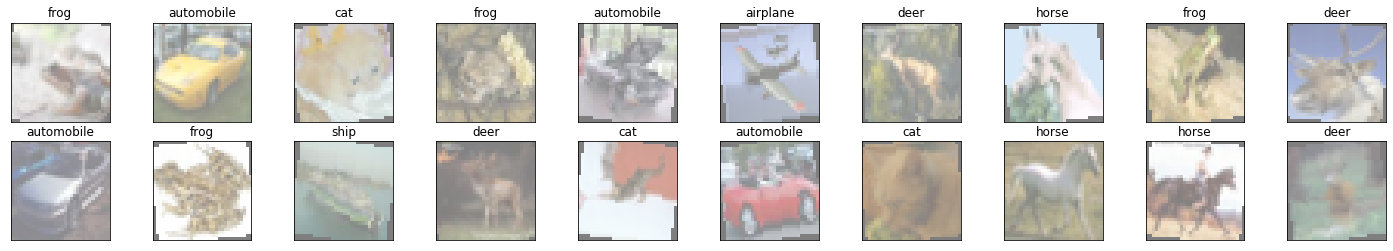

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [13]:
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(0)


# Bayesian AlexNet CIFAR10

In [14]:
net_bay = BBBAlexNet(outputs,inputs)

vi = GaussianVariationalInference(torch.nn.CrossEntropyLoss())
optimizer = optim.Adam(net_bay.parameters(), lr=lr, weight_decay=weight_decay)

In [15]:
ckpt_name_bay = f'model_{net_type}_{dataset}_bayesian_bay.pt'
ckpt_name_bay

'model_alexnet_CIFAR10_bayesian_bay.pt'

In [16]:
%%time

if use_cuda:
    net_bay.cuda()
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    m = math.ceil(len(train_data) / batch_size)
    
    ###################
    # train the model #
    ###################
    net_bay.train()
    for batch_idx, batch_data in enumerate(train_loader, 0):
        # move tensors to GPU if CUDA is available
        
        data, target = batch_data
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0
        optimizer.zero_grad()
        output,kl = net_bay.probforward(data)
        loss = vi(output, target, kl, beta)
        loss.backward()
        optimizer.step()
        train_loss += (loss.item()*data.size(0)) / num_samples
        
    ######################    
    # validate the model #
    ######################
    net_bay.eval()
    for batch_idx, valid_data in enumerate(valid_loader, 0):
        data, target = valid_data
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        output,kl = net_bay.probforward(data)
        loss = vi(output, target, kl, beta)
        # update average validation loss 
        valid_loss += (loss.item()*data.size(0)) / num_samples
        
    # calculate average losses
    train_loss = train_loss/(len(train_loader.dataset) * (1-valid_size))
    valid_loss = valid_loss/(len(valid_loader.dataset) * valid_size)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net_bay.state_dict(), ckpt_name_bay)
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 2.947753 	Validation Loss: 2.385532
Validation loss decreased (inf --> 2.385532).  Saving model ...
Epoch: 2 	Training Loss: 4.468867 	Validation Loss: 4.158264
Epoch: 3 	Training Loss: 6.594492 	Validation Loss: 6.255087
Epoch: 4 	Training Loss: 11.303016 	Validation Loss: 7.951771
Epoch: 5 	Training Loss: 6.293761 	Validation Loss: 15.126927
Epoch: 6 	Training Loss: 7.982263 	Validation Loss: 7.241521
Epoch: 7 	Training Loss: 7.998645 	Validation Loss: 5.168281
Epoch: 8 	Training Loss: 7.601986 	Validation Loss: 16.459098
Epoch: 9 	Training Loss: 10.825525 	Validation Loss: 3.330986
Epoch: 10 	Training Loss: 20.064546 	Validation Loss: 12.720559
Epoch: 11 	Training Loss: 18.612280 	Validation Loss: 26.727796
Epoch: 12 	Training Loss: 20.412098 	Validation Loss: 20.435102
Epoch: 13 	Training Loss: 12.256384 	Validation Loss: 4.175548
Epoch: 14 	Training Loss: 8.520521 	Validation Loss: 9.898821
Epoch: 15 	Training Loss: 11.181386 	Validation Loss: 14.308984
Ep

In [17]:
net_bay.load_state_dict(torch.load(ckpt_name_bay))

<All keys matched successfully>

In [18]:
%%time

if use_cuda:
    net_bay.cuda()


test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net_bay.eval()
m = math.ceil(len(test_data) / batch_size)

for batch_idx, test_data in enumerate(test_loader, 0):
    data, target = test_data
    
    data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
    target = target.repeat(num_samples)
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    
    if beta_type is "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif cf.beta_type is "Soenderby":
        beta = min(epoch / (cf.num_epochs // 4), 1)
    elif cf.beta_type is "Standard":
        beta = 1 / m
    else:
        beta = 0
    output, kl = net_bay.probforward(data)

    loss = vi(output, target, kl, beta)

    test_loss += loss.item()*data.size(0) / num_samples
    #test_loss += loss.item()
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1) 
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if i >= target.data.shape[0]: # batch_size could be greater than left number of images
            break
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 4.509594

Test Accuracy of airplane: 14% (142/1000)
Test Accuracy of automobile: 12% (122/1000)
Test Accuracy of  bird:  4% (48/1000)
Test Accuracy of   cat:  9% (93/1000)
Test Accuracy of  deer: 11% (118/1000)
Test Accuracy of   dog: 12% (129/1000)
Test Accuracy of  frog: 10% (105/1000)
Test Accuracy of horse: 12% (121/1000)
Test Accuracy of  ship:  6% (67/1000)
Test Accuracy of truck:  8% (84/1000)

Test Accuracy (Overall): 10% (1029/10000)
CPU times: user 11.4 s, sys: 500 ms, total: 11.9 s
Wall time: 2.04 s


# Original AlexNet CIFAR10

In [19]:
ckpt_name_ori = f'model_{net_type}_{dataset}_bayesian_ori.pt'
ckpt_name_ori

'model_alexnet_CIFAR10_bayesian_ori.pt'

In [20]:
net_ori = AlexNet(10)
net_ori.apply(conv_init)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_ori.parameters(), lr=lr)

/home/cyp/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  


In [22]:
%%time
if use_cuda:
    net_ori.cuda()

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    net_ori.train()
    for i, batch_data in enumerate(train_loader, 0):
        data, target = batch_data
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = net_ori(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    net_ori.eval()
    for i, valid_data in enumerate(valid_loader, 0):
        data, target = valid_data
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net_ori(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net_ori.state_dict(), ckpt_name_ori)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 32.462769 	Validation Loss: 2.333748
Validation loss decreased (inf --> 2.333748).  Saving model ...
Epoch: 2 	Training Loss: 21.744005 	Validation Loss: 1.109918
Validation loss decreased (2.333748 --> 1.109918).  Saving model ...
Epoch: 3 	Training Loss: 13.500141 	Validation Loss: 0.999206
Validation loss decreased (1.109918 --> 0.999206).  Saving model ...
Epoch: 4 	Training Loss: 8.744522 	Validation Loss: 0.964235
Validation loss decreased (0.999206 --> 0.964235).  Saving model ...
Epoch: 5 	Training Loss: 7.431800 	Validation Loss: 0.760224
Validation loss decreased (0.964235 --> 0.760224).  Saving model ...
Epoch: 6 	Training Loss: 5.585437 	Validation Loss: 0.638145
Validation loss decreased (0.760224 --> 0.638145).  Saving model ...
Epoch: 7 	Training Loss: 4.130836 	Validation Loss: 0.593816
Validation loss decreased (0.638145 --> 0.593816).  Saving model ...
Epoch: 8 	Training Loss: 3.584505 	Validation Loss: 0.515811
Validation loss decreased (0.59

In [23]:
net_ori.load_state_dict(torch.load(ckpt_name_ori))

<All keys matched successfully>

In [24]:
%%time

if use_cuda:
    net_ori.cuda()
# track test loss# track  
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net_ori.eval()

for i, test_data in enumerate(test_loader, 0):
    data, target = test_data
    if use_cuda:
        data, target = data.cuda(), target.cuda()

    output = net_ori(data)

    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)    

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if i >= target.data.shape[0]: # batch_size could be greater than left number of images
            break
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.332783

Test Accuracy of airplane:  0% ( 0/1000)
Test Accuracy of automobile:  0% ( 0/1000)
Test Accuracy of  bird:  0% ( 0/1000)
Test Accuracy of   cat:  0% ( 0/1000)
Test Accuracy of  deer:  0% ( 0/1000)
Test Accuracy of   dog: 100% (1000/1000)
Test Accuracy of  frog:  0% ( 0/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship:  0% ( 0/1000)
Test Accuracy of truck:  0% ( 0/1000)

Test Accuracy (Overall): 10% (1000/10000)
CPU times: user 954 ms, sys: 216 ms, total: 1.17 s
Wall time: 1.22 s


In [26]:
ls = [[1,2], [3, 4], [5, 6]]
import numpy as np
